In [22]:
# Proposed

iter= 0 , loss= 0.37363473
iter= 10 , loss= 0.13468234
iter= 20 , loss= 0.11874291
iter= 30 , loss= 0.11018579
iter= 40 , loss= 0.10630064
iter= 50 , loss= 0.10189013
iter= 60 , loss= 0.09679428
iter= 70 , loss= 0.09096542
iter= 80 , loss= 0.08434002
iter= 90 , loss= 0.07786813
iter= 100 , loss= 0.07261384
iter= 110 , loss= 0.069168106
iter= 120 , loss= 0.06614674
iter= 130 , loss= 0.062378556
iter= 140 , loss= 0.057643477
iter= 150 , loss= 0.050653033
iter= 160 , loss= 0.06145862
iter= 170 , loss= 0.043927684
iter= 180 , loss= 0.03900197
iter= 190 , loss= 0.032110993
iter= 200 , loss= 0.04537995
iter= 210 , loss= 0.033200745
iter= 220 , loss= 0.02788805
iter= 230 , loss= 0.023416895
iter= 240 , loss= 0.028091416
iter= 250 , loss= 0.021264106
iter= 260 , loss= 0.02216323
iter= 270 , loss= 0.025207281
iter= 280 , loss= 0.023218112
iter= 290 , loss= 0.019029835

Computation time of adam: 18.99514126777649 seconds
iter= 300 , loss= 0.016069121658802032
iter= 310 , loss= 0.0146306846290826

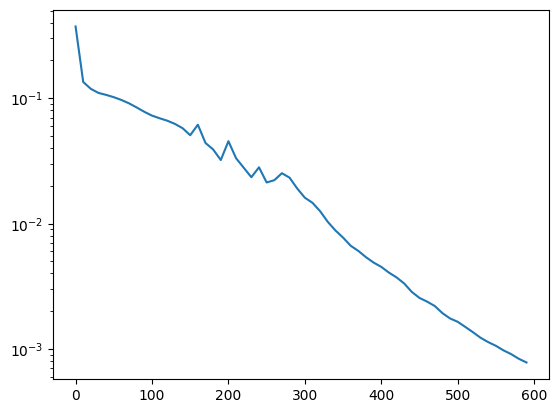

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
from time import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


class Proposed(tf.keras.initializers.Initializer):
    def __call__(self, shape, dtype=None):
        m, n = shape
        
        if m >= n:
            identity_matrix = np.eye(m, n, dtype=np.float32)
        else:
            identity_matrix = np.zeros((n, m), dtype=np.float32)
            for i in range(n):
                identity_matrix[i, i % m] = 1
            identity_matrix = identity_matrix.transpose()
        
        std = 0.085 * (1 / np.sqrt(n))
        noise = np.random.normal(0, std, size=(shape[0], shape[1]))
        identity_matrix += noise
        return identity_matrix

def burgers_data():
    N_b = 500    # boundary
    N_t = 500    # initial time
    N_c = 20000  # collocation point

    xmin = -1.0
    xmax = 1.0
    tmin = 0.0
    tmax = 1.0

    initial_xt = np.linspace([xmin, tmin], [xmax, tmin], N_t)
    initial_u = -np.sin(np.pi * initial_xt[:,0]).reshape(-1,1)

    boundary_up = np.linspace([xmax, tmin], [xmax, tmax], N_b)
    boundary_up_sol = np.zeros((N_b, 1))
    boundary_down = np.linspace([xmin, tmin], [xmin, tmax], N_b)
    boundary_down_sol = np.zeros((N_b, 1))

    xt_bnd = np.concatenate([initial_xt, boundary_up, boundary_down], axis=0)
    u_bnd_sol = np.concatenate([initial_u, boundary_up_sol, boundary_down_sol], axis=0)

    t_col_data = np.random.uniform(tmin, tmax, [N_c, 1])
    x_col_data = np.random.uniform(xmin, xmax, [N_c, 1])
    xt_col_data = np.concatenate([x_col_data, t_col_data], axis=1)
    xt_col = np.concatenate((xt_col_data, xt_bnd), axis=0)

    xt_col = tf.convert_to_tensor(xt_col, dtype=tf.float32)
    xt_bnd = tf.convert_to_tensor(xt_bnd, dtype=tf.float32)
    u_bnd_sol = tf.convert_to_tensor(u_bnd_sol, dtype=tf.float32)

    return xt_col, xt_bnd, u_bnd_sol


numbers = [30]

for num in numbers:
    exec(f'proposed16_{num} = []')
    for _ in range(1):
        loss_list1 = []

        class Burgers(Model):
            def __init__(self):
                super(Burgers, self).__init__()
                initializer = tf.keras.initializers.GlorotNormal()
                self.hidden_layers = [Dense(16, activation='tanh', kernel_initializer=Proposed()) for _ in range(num)]
                self.u = Dense(1, activation='linear', kernel_initializer=Proposed())
        
            def call(self, state):
                x = state
                for layer in self.hidden_layers:
                    x = layer(x)
                out = self.u(x)
                return out
        
        class BurgersPinn(object):
        
            def __init__(self):
        
                self.lr = 0.001
                self.opt = Adam(self.lr)
        
                self.burgers = Burgers()
                self.burgers.build(input_shape=(None, 2))
        
                self.train_loss_history = []
                self.iter_count = 0
                self.instant_loss = 0
        
            @tf.function
            def physics_net(self, xt):
                x = xt[:, 0:1]
                t = xt[:, 1:2]
                xt_t = tf.concat([x, t], 1)
                u = self.burgers(xt_t)
                u_x = tf.gradients(u, x)
                u_xx = tf.gradients(u_x, x)
                u_t = tf.gradients(u, t)
        
                return u_t + u*u_x - (0.01/tf.constant(np.pi))*u_xx
        
        
            def save_weights(self, path):
                self.burgers.save_weights(path + 'burgers1.h5')
        
        
            def load_weights(self, path):
                self.burgers.load_weights(path + 'burgers1.h5')
        
        
            def compute_loss(self, f, u_bnd_hat, u_bnd_sol):
        
                loss_col = tf.reduce_mean(tf.square(f))
                loss_bnd = tf.reduce_mean(tf.square(u_bnd_hat - u_bnd_sol))
        
                loss = loss_col + loss_bnd
        
                return loss
        
        
        
            def compute_grad(self, xt_col, xt_bnd, u_bnd_sol):
                with tf.GradientTape() as tape:
                    f = self.physics_net(xt_col)
                    u_bnd_hat = self.burgers(xt_bnd)
        
                    loss = self.compute_loss(f, u_bnd_hat, u_bnd_sol)
        
                grads = tape.gradient(loss, self.burgers.trainable_variables)
        
                return loss, grads
        
        
            def callback(self, arg=None):
                if self.iter_count % 10 == 0:
                    print('iter=', self.iter_count, ', loss=', self.instant_loss)
                    self.train_loss_history.append([self.iter_count, self.instant_loss])
                self.iter_count += 1
        
        
        
            def train_with_adam(self, xt_col, xt_bnd, u_bnd_sol, adam_num):
        
                def learn():
                    loss, grads = self.compute_grad(xt_col, xt_bnd, u_bnd_sol)
        
                    self.opt.apply_gradients(zip(grads, self.burgers.trainable_variables))
        
                    return loss
        
                for iter in range(int(adam_num)):
        
                    loss = learn()
        
                    self.instant_loss = loss.numpy()
                    self.callback()
        
        
            def train_with_lbfgs(self, xt_col, xt_bnd, u_bnd_sol, lbfgs_num):
        
                def vec_weight():
                    weight_vec = []
                    for v in self.burgers.trainable_variables:
                        weight_vec.extend(v.numpy().flatten())
        
                    weight_vec = tf.convert_to_tensor(weight_vec)
                    return weight_vec
                w0 = vec_weight().numpy()
        
                def restore_weight(weight_vec):
                    idx = 0
                    for v in self.burgers.trainable_variables:
                        vs = v.shape
        
                        if len(vs) == 2:
                            sw = vs[0] * vs[1]
                            updated_val = tf.reshape(weight_vec[idx:idx + sw], (vs[0], vs[1]))
                            idx += sw
        
                        elif len(vs) == 1:
                            updated_val = weight_vec[idx:idx + vs[0]]
                            idx += vs[0]
        
                        v.assign(tf.cast(updated_val, dtype=tf.float32))
        
        
                def loss_grad(w):
                    restore_weight(w)
                    loss, grads = self.compute_grad(xt_col, xt_bnd, u_bnd_sol)
                    grad_vec = []
                    for g in grads:
                        grad_vec.extend(g.numpy().flatten())
        

                    loss = loss.numpy().astype(np.float64)
                    self.instant_loss = loss
                    grad_vec = np.array(grad_vec, dtype=np.float64)
        
                    return loss, grad_vec
        
                return scipy.optimize.minimize(fun=loss_grad,
                                               x0=w0,
                                               jac=True,
                                               method='L-BFGS-B',
                                               callback=self.callback,
                                               options={'maxiter': lbfgs_num,
                                                        'maxfun': 50000,
                                                        'maxcor': 50,
                                                        'maxls': 50,
                                                        'ftol': 1.0 * np.finfo(float).eps})
        
        
            def predict(self, xt):
                u_pred = self.burgers(xt)
                return u_pred
        
        
            def train(self, adam_num, lbfgs_num):
                xt_col, xt_bnd, u_bnd_sol = burgers_data()
                t0 = time()
                self.train_with_adam(xt_col, xt_bnd, u_bnd_sol, adam_num)
                print('\nComputation time of adam: {} seconds'.format(time() - t0))
                t1 = time()
                self.train_with_lbfgs(xt_col, xt_bnd, u_bnd_sol, lbfgs_num)
                print('\nComputation time of L-BFGS-B: {} seconds'.format(time() - t1))      
                self.save_weights("./save_weights/")        
                np.savetxt('./save_weights/loss.txt', self.train_loss_history)
                train_loss_history = np.array(self.train_loss_history)
                loss_list1.append(train_loss_history)
                plt.plot(train_loss_history[:, 0], train_loss_history[:, 1])
                plt.yscale("log")
                plt.show()
        
        with tf.device('/GPU:0'):
            def main():
        
                adam_num = 300
                lbfgs_num = 300
                agent = BurgersPinn()
        
                agent.train(adam_num, lbfgs_num)
        
            if __name__=="__main__":
                main()
            exec(f'proposed16_{num}.append(np.array(loss_list1)[:,:,1][0])')

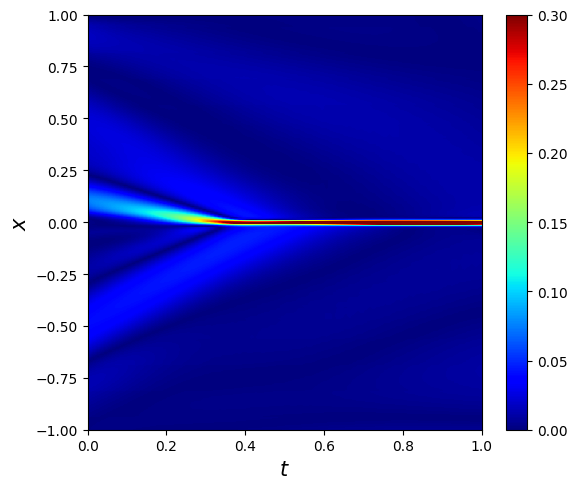

In [21]:
burgers_sol = np.load('Burgers.npz')
usol = burgers_sol['usol']

x_input = np.linspace(-1.0, 1.0, 256)
t_input = np.linspace(0.0, 1.0, 100)
x_data = x_input.reshape(-1,1)
uxt_res = []

agent = BurgersPinn()
agent.load_weights('./save_weights/')

for t in t_input:
    t_data = t * np.ones(x_data.shape)
    xt_data = np.concatenate([x_data, t_data], axis=1)
    u_pred = agent.predict(tf.convert_to_tensor(xt_data, dtype=tf.float32))
    uxt = np.concatenate([xt_data, u_pred.numpy()], axis=1)
    uxt_res.append(uxt)

uxt_res1 = np.array(uxt_res)
uxt_res = uxt_res1.reshape(-1, 3)
plt.figure(figsize=(6, 5))
plt.imshow(abs(usol - uxt_res1[:, :, 2].transpose()), 
           extent=[0, 1, -1, 1], 
           origin='lower', 
           aspect='auto', 
           cmap='jet', 
           vmin=0, vmax=0.3)
plt.colorbar()
plt.xlabel('$t$', size=15)
plt.ylabel('$x$', size=15)
plt.tight_layout()
plt.show()

In [23]:
# Xavier

iter= 0 , loss= 0.14119606
iter= 10 , loss= 0.1274857
iter= 20 , loss= 0.12262217
iter= 30 , loss= 0.117449425
iter= 40 , loss= 0.10421642
iter= 50 , loss= 0.09453082
iter= 60 , loss= 0.0842794
iter= 70 , loss= 0.079394735
iter= 80 , loss= 0.077530146
iter= 90 , loss= 0.07583224
iter= 100 , loss= 0.07475258
iter= 110 , loss= 0.073775135
iter= 120 , loss= 0.07191425
iter= 130 , loss= 0.083376974
iter= 140 , loss= 0.07340782
iter= 150 , loss= 0.07012268
iter= 160 , loss= 0.06862028
iter= 170 , loss= 0.067220464
iter= 180 , loss= 0.06583758
iter= 190 , loss= 0.0690506
iter= 200 , loss= 0.06374899
iter= 210 , loss= 0.062438093
iter= 220 , loss= 0.060428545
iter= 230 , loss= 0.0589172
iter= 240 , loss= 0.057283323
iter= 250 , loss= 0.05583803
iter= 260 , loss= 0.05416538
iter= 270 , loss= 0.0530273
iter= 280 , loss= 0.05174522
iter= 290 , loss= 0.05137664

Computation time of adam: 18.32184910774231 seconds
iter= 300 , loss= 0.04910219833254814
iter= 310 , loss= 0.048239029943943024
iter= 3

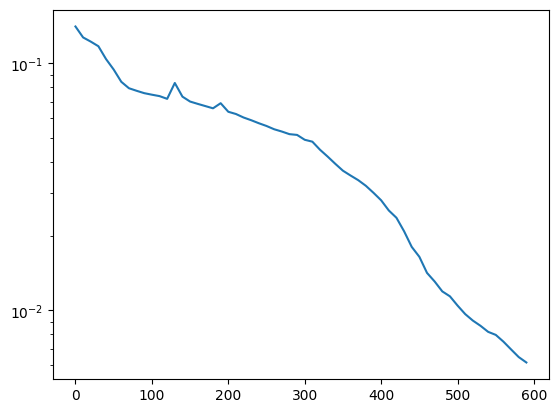

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
from time import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt



def burgers_data():
    N_b = 500    # boundary
    N_t = 500    # initial time
    N_c = 20000  # collocation point

    xmin = -1.0
    xmax = 1.0
    tmin = 0.0
    tmax = 1.0

    initial_xt = np.linspace([xmin, tmin], [xmax, tmin], N_t)
    initial_u = -np.sin(np.pi * initial_xt[:,0]).reshape(-1,1)

    boundary_up = np.linspace([xmax, tmin], [xmax, tmax], N_b)
    boundary_up_sol = np.zeros((N_b, 1))
    boundary_down = np.linspace([xmin, tmin], [xmin, tmax], N_b)
    boundary_down_sol = np.zeros((N_b, 1))

    xt_bnd = np.concatenate([initial_xt, boundary_up, boundary_down], axis=0)
    u_bnd_sol = np.concatenate([initial_u, boundary_up_sol, boundary_down_sol], axis=0)


    t_col_data = np.random.uniform(tmin, tmax, [N_c, 1])
    x_col_data = np.random.uniform(xmin, xmax, [N_c, 1])
    xt_col_data = np.concatenate([x_col_data, t_col_data], axis=1)
    xt_col = np.concatenate((xt_col_data, xt_bnd), axis=0)

    xt_col = tf.convert_to_tensor(xt_col, dtype=tf.float32)
    xt_bnd = tf.convert_to_tensor(xt_bnd, dtype=tf.float32)
    u_bnd_sol = tf.convert_to_tensor(u_bnd_sol, dtype=tf.float32)
    return xt_col, xt_bnd, u_bnd_sol


numbers = [30]

for num in numbers:
    exec(f'xavier16_{num} = []')
    for _ in range(1):
        loss_list1 = []

        class Burgers(Model):
            def __init__(self):
                super(Burgers, self).__init__()
                initializer = tf.keras.initializers.GlorotNormal()
                self.hidden_layers = [Dense(16, activation='tanh') for _ in range(num)]
                self.u = Dense(1, activation='linear')
        
            def call(self, state):
                x = state
                for layer in self.hidden_layers:
                    x = layer(x)
                out = self.u(x)
                return out
        
        class BurgersPinn(object):
        
            def __init__(self):
        
                self.lr = 0.001
                self.opt = Adam(self.lr)
        
                self.burgers = Burgers()
                self.burgers.build(input_shape=(None, 2))
        
                self.train_loss_history = []
                self.iter_count = 0
                self.instant_loss = 0
        
            @tf.function
            def physics_net(self, xt):
                x = xt[:, 0:1]
                t = xt[:, 1:2]
                xt_t = tf.concat([x, t], 1)
                u = self.burgers(xt_t)
                u_x = tf.gradients(u, x)
                u_xx = tf.gradients(u_x, x)
                u_t = tf.gradients(u, t)
        
                return u_t + u*u_x - (0.01/tf.constant(np.pi))*u_xx
        
        
            def save_weights(self, path):
                self.burgers.save_weights(path + 'burgers1.h5')
        
        
            def load_weights(self, path):
                self.burgers.load_weights(path + 'burgers1.h5')
        
        
            def compute_loss(self, f, u_bnd_hat, u_bnd_sol):
        
                loss_col = tf.reduce_mean(tf.square(f))
                loss_bnd = tf.reduce_mean(tf.square(u_bnd_hat - u_bnd_sol))
        
                loss = loss_col + loss_bnd
        
                return loss
        
        
        
            def compute_grad(self, xt_col, xt_bnd, u_bnd_sol):
                with tf.GradientTape() as tape:
                    f = self.physics_net(xt_col)
                    u_bnd_hat = self.burgers(xt_bnd)
        
                    loss = self.compute_loss(f, u_bnd_hat, u_bnd_sol)
        
                grads = tape.gradient(loss, self.burgers.trainable_variables)
        
                return loss, grads
        
        
            def callback(self, arg=None):
                if self.iter_count % 10 == 0:
                    print('iter=', self.iter_count, ', loss=', self.instant_loss)
                    self.train_loss_history.append([self.iter_count, self.instant_loss])
                self.iter_count += 1
        
        
        
            def train_with_adam(self, xt_col, xt_bnd, u_bnd_sol, adam_num):
        
                def learn():
                    loss, grads = self.compute_grad(xt_col, xt_bnd, u_bnd_sol)
        
                    self.opt.apply_gradients(zip(grads, self.burgers.trainable_variables))
        
                    return loss
        
                for iter in range(int(adam_num)):
        
                    loss = learn()
        
                    self.instant_loss = loss.numpy()
                    self.callback()
        
        
            def train_with_lbfgs(self, xt_col, xt_bnd, u_bnd_sol, lbfgs_num):

                def vec_weight():
                    weight_vec = []
        
                    for v in self.burgers.trainable_variables:
                        weight_vec.extend(v.numpy().flatten())
        
                    weight_vec = tf.convert_to_tensor(weight_vec)
                    return weight_vec
                w0 = vec_weight().numpy()
        
                def restore_weight(weight_vec):
                    idx = 0
                    for v in self.burgers.trainable_variables:
                        vs = v.shape
        
                        if len(vs) == 2:
                            sw = vs[0] * vs[1]
                            updated_val = tf.reshape(weight_vec[idx:idx + sw], (vs[0], vs[1]))
                            idx += sw
        
                        elif len(vs) == 1:
                            updated_val = weight_vec[idx:idx + vs[0]]
                            idx += vs[0]
        
                        v.assign(tf.cast(updated_val, dtype=tf.float32))
        
        
                def loss_grad(w):
                    restore_weight(w)
                    loss, grads = self.compute_grad(xt_col, xt_bnd, u_bnd_sol)
                    grad_vec = []
                    for g in grads:
                        grad_vec.extend(g.numpy().flatten())
                    loss = loss.numpy().astype(np.float64)
                    self.instant_loss = loss
                    grad_vec = np.array(grad_vec, dtype=np.float64)
        
                    return loss, grad_vec
        
                return scipy.optimize.minimize(fun=loss_grad,
                                               x0=w0,
                                               jac=True,
                                               method='L-BFGS-B',
                                               callback=self.callback,
                                               options={'maxiter': lbfgs_num,
                                                        'maxfun': 50000,
                                                        'maxcor': 50,
                                                        'maxls': 50,
                                                        'ftol': 1.0 * np.finfo(float).eps})
        
        
            def predict(self, xt):
                u_pred = self.burgers(xt)
                return u_pred
        
        
            def train(self, adam_num, lbfgs_num):
                xt_col, xt_bnd, u_bnd_sol = burgers_data()
                t0 = time()
                self.train_with_adam(xt_col, xt_bnd, u_bnd_sol, adam_num)
                print('\nComputation time of adam: {} seconds'.format(time() - t0))
                t1 = time()
                self.train_with_lbfgs(xt_col, xt_bnd, u_bnd_sol, lbfgs_num)
                print('\nComputation time of L-BFGS-B: {} seconds'.format(time() - t1))
                self.save_weights("./save_weights/")
                np.savetxt('./save_weights/loss.txt', self.train_loss_history)
                train_loss_history = np.array(self.train_loss_history)
                loss_list1.append(train_loss_history)
                plt.plot(train_loss_history[:, 0], train_loss_history[:, 1])
                plt.yscale("log")
                plt.show()
        

        with tf.device('/GPU:0'):
            def main():
        
                adam_num = 300
                lbfgs_num = 300
                agent = BurgersPinn()
        
                agent.train(adam_num, lbfgs_num)
        
            if __name__=="__main__":
                main()
            exec(f'xavier16_{num}.append(np.array(loss_list1)[:,:,1][0])')


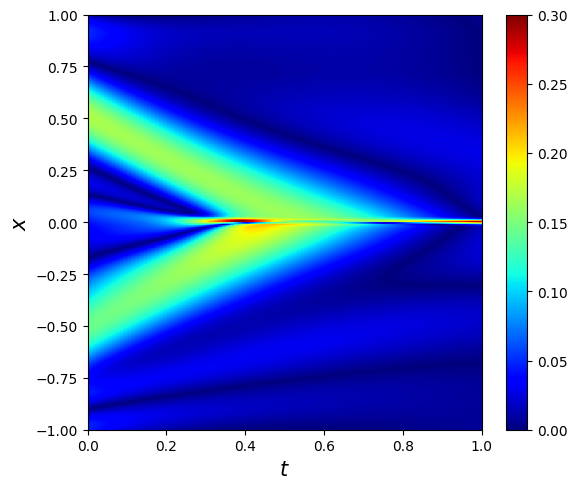

In [18]:
burgers_sol = np.load('Burgers.npz')
usol = burgers_sol['usol']
x_input = np.linspace(-1.0, 1.0, 256)
t_input = np.linspace(0.0, 1.0, 100)
x_data = x_input.reshape(-1,1)
uxt_res = []

agent = BurgersPinn()
agent.load_weights('./save_weights/')

for t in t_input:
    t_data = t * np.ones(x_data.shape)
    xt_data = np.concatenate([x_data, t_data], axis=1)
    u_pred = agent.predict(tf.convert_to_tensor(xt_data, dtype=tf.float32))
    uxt = np.concatenate([xt_data, u_pred.numpy()], axis=1)
    uxt_res.append(uxt)

uxt_res1 = np.array(uxt_res)
uxt_res = uxt_res1.reshape(-1, 3)
plt.figure(figsize=(6, 5))
plt.imshow(abs(usol - uxt_res1[:, :, 2].transpose()), 
           extent=[0, 1, -1, 1], 
           origin='lower', 
           aspect='auto', 
           cmap='jet', 
           vmin=0, vmax=0.3)
plt.colorbar()
plt.xlabel('$t$', size=15)
plt.ylabel('$x$', size=15)


plt.tight_layout()
plt.show()

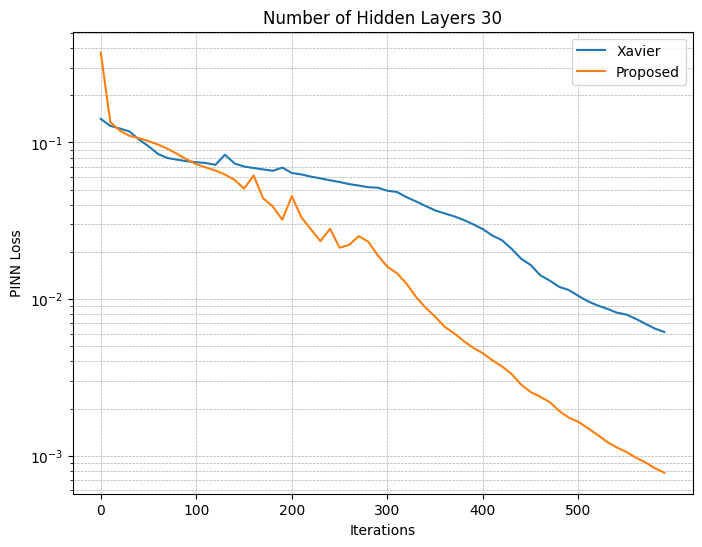

In [30]:
plt.figure(figsize=(8, 6))
plt.plot(xavier16_30[0], label='Xavier')
plt.plot(proposed16_30[0], label='Proposed')
plt.legend()
plt.title('Number of Hidden Layers 30')
plt.yscale('log')  # Logarithmic scale for y-axis

# Adjusting x-axis ticks to be 10x the index values
plt.xlabel('Iterations')
plt.ylabel('PINN Loss')
plt.xticks(ticks=range(0, 60, 10), labels=[str(i * 10) for i in range(0, 60, 10)])
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()